In [1]:
from IPython.core.display import display, HTML, Image
display(HTML("<style>.container { width:100% !important; }</style>"))
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

np.set_printoptions(precision=4, suppress=True, linewidth=120)

,time,ind_fact,ind_x,seg_fact_0,seg_x_0,seg_fact_1,seg_x_1,sub_fact_0,sub_x_0,sub_fact_1,...,y_1_0,y_1_1,y_1_2,y_1_3,y_1_4,y_1_5,y_1_6,y_1_7,y_1_8,y_1_9
0,2006-01-01,0.617965,0.654700,0.517785,0.200695,-0.999200,0.259699,-0.601661,0.320737,-2.880944,...,-0.297938,-1.181501,-0.676901,-1.365916,-0.372106,-0.749382,-0.903947,0.015604,-0.162308,0.295516
1,2006-02-01,0.834329,0.525347,-0.303949,-0.666398,-1.807114,-1.107674,1.130150,1.370814,-1.332009,...,2.882121,1.391573,1.387025,0.811339,1.395260,0.985979,0.379068,0.181094,0.685022,0.945873
2,2006-03-01,-0.619074,-1.036238,-1.258184,-1.045420,0.595070,1.860050,0.943967,0.491907,1.535079,...,-0.481287,-0.453584,-0.923026,-0.430592,-0.464370,-1.277366,-2.962879,-0.886226,0.532460,-0.065429
3,2006-04-01,-0.951931,-0.642394,-1.439187,-0.558457,1.510847,1.094298,-1.245657,-1.623244,0.555072,...,1.305204,0.158532,0.665303,0.355082,-1.466140,0.113535,0.708410,-0.213894,-1.390239,0.759290
4,2006-05-01,-0.622445,-0.146479,0.117217,1.124647,0.432032,-0.625561,-1.299055,-0.800792,0.722353,...,0.922735,-0.808731,1.370731,1.080700,1.329639,1.984177,1.512863,-0.218567,1.245510,-0.044662


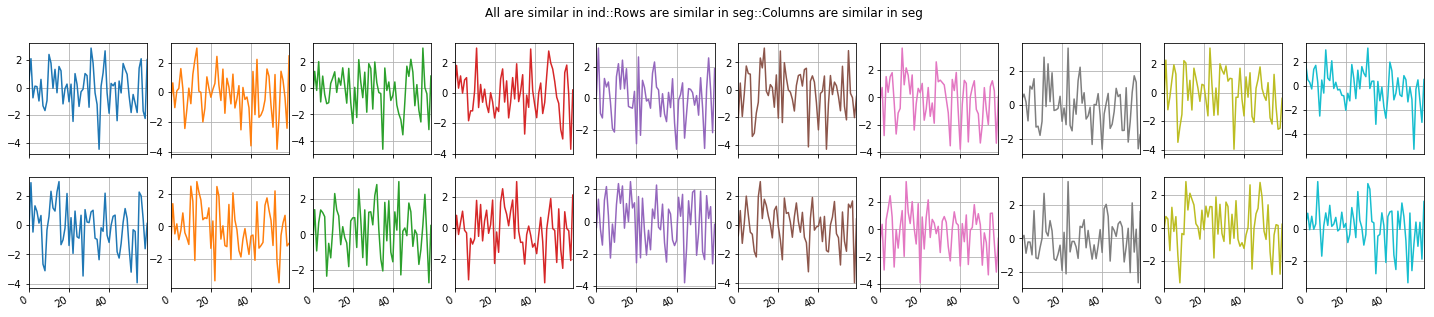

In [3]:
###simulate time series data 
periods=1000
seed=98165
# factor_model=pd.DataFrame(pd.date_range(start='1/1/2018', end='2/1/2019', freq='M', normalize=True),columns=['time']).astype('datetime64[M]')

factor_model=pd.DataFrame(pd.date_range(start='1/1/2006', periods=periods, freq='M', normalize=True),columns=['time']).astype('datetime64[M]')

np.random.seed(seed)

def factor_gen(size=periods, beta=0.8, burner=2, scale=1):
    j=burner+size
    x=np.random.normal(loc=0.0, scale=scale, size=j)
    
    y=[0]*j
    for i in range(j):
        
        if i==0:
            y0=0 
        else:
            y[i]=beta*y0 + x[i]
            y0=y[i]
            
    return y[-size:], x[-size:]

###industry factor
fact_name='ind_fact'
fact_name_x='ind_x'
fact, fact_x = factor_gen(size=periods, beta=0.5, burner=200)
factor_model[fact_name]=fact 
factor_model[fact_name_x]=fact_x 

###segment factor
seg=2
sub=10
for i in range(seg):
    fact_name='seg_fact_'+str(i)
    fact_name_x='seg_x_'+str(i)
    fact, fact_x = factor_gen(size=periods, beta=0.7, burner=200)
    factor_model[fact_name]=fact 
    factor_model[fact_name_x]=fact_x 

###brand factor
for i in range(sub):
    fact_name='sub_fact_'+str(i)
    fact_name_x='sub_x_'+str(i)
    fact, fact_x = factor_gen(size=periods, beta=0.4, burner=200)
    factor_model[fact_name]=fact 
    factor_model[fact_name_x]=fact_x 
    
###idiosyncratic factor
for s in range(seg):
    for b in range(sub):
        fact_name='idi_fact_' + str(s) + '_' + str(b)
        fact_name_x='idi_fact_x' + str(s) + '_' + str(b)
        fact, fact_x = factor_gen(size=periods, beta=0.0, burner=200, scale=1)
        factor_model[fact_name]=fact
        factor_model[fact_name_x]=fact_x

factor_model['x1']=pd.DataFrame(np.random.normal(loc=0.0, scale=1, size=periods))
factor_model['x2']=pd.DataFrame(np.random.normal(loc=0.0, scale=1, size=periods))  
factor_model['x3']=pd.DataFrame(np.random.normal(loc=0.0, scale=1, size=periods)) 
factor_model['x4']=pd.DataFrame(np.random.normal(loc=0.0, scale=1, size=periods)) 
factor_model['x5']=pd.DataFrame(np.random.normal(loc=0.0, scale=1, size=periods)) 
factor_model['x6']=pd.DataFrame(np.random.normal(loc=0.0, scale=1, size=periods))
factor_model['x7']=pd.DataFrame(np.random.normal(loc=0.0, scale=1, size=periods))
factor_model['x8']=pd.DataFrame(np.random.normal(loc=0.0, scale=1, size=periods)) 
factor_model['x9']=pd.DataFrame(np.random.normal(loc=0.0, scale=1, size=periods))
factor_model['x10']=pd.DataFrame(np.random.normal(loc=0.0, scale=1, size=periods))


        
###observed y --output

for s in range(seg):
    for b in range(sub):
        fact_name='y_' + str(s) + '_' + str(b)
        seg_fact='seg_fact_' + str(s)
        sub_fact='sub_fact_' + str(b)
        idi_fact= 'idi_fact_' + str(s) + '_' + str(b)
#         factor_model[fact_name]=factor_model['ind_fact']+factor_model[seg_fact] + factor_model[sub_fact] + factor_model[idi_fact]
#         factor_model[fact_name]=factor_model['ind_fact'] +factor_model[seg_fact] + factor_model[idi_fact] + 2*factor_model['x1'] -  2*factor_model['x2']
        factor_model[fact_name]=factor_model['ind_fact']  + factor_model[idi_fact] + 0.2*factor_model['x1'] -  0.2*factor_model['x2'] \
        + 0.2*factor_model['x3'] -  0.2*factor_model['x4'] + 0.2*factor_model['x5'] -  0.2*factor_model['x6'] \
        + 0.2*factor_model['x7'] -  0.2*factor_model['x8'] + 0.2*factor_model['x9'] -  0.2*factor_model['x10'] 
        factor_model[fact_name_x]=fact_x
    
# print(factor_model.columns)
_=factor_model[[name for name in factor_model.columns if 'y_' in name]][(
    factor_model.time.dt.year<=2010)].plot(subplots=True, layout=( seg,sub), figsize=(25, 5), grid=True, legend=False, 
                                           title='All are similar in ind::Rows are similar in seg::Columns are similar in seg')
factor_model.head(5)
factor_model.to_csv(r'c:\temp\to_sas.csv')

In [6]:
factor_model.describe()

,ind_fact,ind_x,seg_fact_0,seg_x_0,seg_fact_1,seg_x_1,sub_fact_0,sub_x_0,sub_fact_1,sub_x_1,...,y_1_0,y_1_1,y_1_2,y_1_3,y_1_4,y_1_5,y_1_6,y_1_7,y_1_8,y_1_9
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.018148,0.008417,-0.109945,-0.034714,-0.047515,-0.012647,0.123187,0.074395,-0.027983,-0.016488,...,0.002434,-0.043469,0.040990,0.017242,0.035286,-0.008626,-0.032957,0.023456,0.019839,-0.013234
std,1.129751,0.995504,1.340804,0.989485,1.367386,0.984107,1.143553,1.049514,1.108391,1.016756,...,1.672681,1.665505,1.650981,1.657165,1.690633,1.615151,1.715656,1.664972,1.617406,1.605034
min,-3.707848,-2.841188,-4.454325,-3.010521,-4.390747,-3.477704,-3.726382,-3.710776,-3.483179,-3.657070,...,-5.598812,-4.715933,-5.722524,-4.413147,-5.099335,-5.641467,-8.080608,-4.615959,-6.138622,-5.434010
25%,-0.757788,-0.635604,-1.031271,-0.715199,-0.960195,-0.653113,-0.620086,-0.643451,-0.755486,-0.677261,...,-1.153896,-1.173226,-1.051336,-1.071197,-1.156920,-1.065274,-1.171477,-1.091966,-1.049628,-1.113883
50%,0.038500,0.028063,-0.138936,-0.049871,-0.003217,0.001217,0.127841,0.080193,-0.017323,-0.014763,...,0.017851,-0.043354,0.147273,0.020379,0.114030,-0.022503,0.078220,0.105500,-0.036546,0.037816
75%,0.768605,0.684293,0.770148,0.624105,0.946999,0.665830,0.883535,0.787927,0.710120,0.707621,...,1.143639,1.117083,1.142162,1.076810,1.250773,1.077785,1.089255,1.119865,1.189995,1.037814
max,3.464417,2.685126,4.280045,2.995209,3.584190,3.259324,3.830799,3.390959,3.316944,2.985808,...,5.325082,4.844893,4.645110,5.109035,4.463946,5.414955,6.021741,5.638967,5.508736,4.695231


In [4]:
# mod = sm.tsa.DynamicFactor(endog,  k_factors=1, factor_order=1)
endog=factor_model[[name for name in factor_model.columns if 'y_' in name]]
exog=factor_model[['x1','x2']]

import time

parameters_all=pd.DataFrame()

for i in range(4):

    idx=(i+1)*250
    endog1=endog[0:idx]
    exog1=exog[0:idx]

    print( i, ') ')
    ts=time.time()
    mod = sm.tsa.DynamicFactor(endog1, exog=exog1, k_factors=1, factor_order=1)
    initial_res = mod.fit(method='powell', disp=True)
    res = mod.fit(initial_res.params, disp=True, maxiter=5000)
    time_elps=time.time()-ts
    print( i, ')  time_elps: ----> ', time_elps)
    parameters=pd.DataFrame()
    parameters['params']=res.params
    parameters['std']=np.diag(res.cov_params_default)**(0.5)
    parameters['tvalues']=res.tvalues
    parameters[['p025', 'p975']]=res.conf_int()
    parameters['nobs']=res.nobs
    parameters['llf']=res.llf
    parameters['time']=time_elps
    parameters_all=parameters_all.append(parameters)

parameters_all.to_csv(r'c:\temp\x1.csv')    

0 ) 
Optimization terminated successfully.
         Current function value: 30.008611
         Iterations: 10
         Function evaluations: 8348
0 )  time_elps: ---->  19.551644563674927
1 ) 
Optimization terminated successfully.
         Current function value: 30.145876
         Iterations: 12
         Function evaluations: 10244
1 )  time_elps: ---->  40.46920919418335
2 ) 
Optimization terminated successfully.
         Current function value: 30.553116
         Iterations: 12
         Function evaluations: 10169
2 )  time_elps: ---->  62.23431348800659
3 ) 
Optimization terminated successfully.
         Current function value: 30.569235
         Iterations: 12
         Function evaluations: 10229
3 )  time_elps: ---->  79.25619888305664


In [5]:
# mod = sm.tsa.DynamicFactor(endog,  k_factors=1, factor_order=1)
endog=factor_model[[name for name in factor_model.columns if 'y_' in name]]
exog=factor_model[['x1']]

import time

parameters_all=pd.DataFrame()

for i in range(4):

    idx=(i+1)*250
    endog1=endog[0:idx]
    exog1=exog[0:idx]

    print( i, ') ')
    ts=time.time()
    mod = sm.tsa.DynamicFactor(endog1, exog=exog1, k_factors=1, factor_order=1)
    initial_res = mod.fit(method='powell', disp=True)
    res = mod.fit(initial_res.params, disp=True, maxiter=5000)
    time_elps=time.time()-ts
    print( i, ')  time_elps: ----> ', time_elps)
    parameters=pd.DataFrame()
    parameters['params']=res.params
    parameters['std']=np.diag(res.cov_params_default)**(0.5)
    parameters['tvalues']=res.tvalues
    parameters[['p025', 'p975']]=res.conf_int()
    parameters['nobs']=res.nobs
    parameters['llf']=res.llf
    parameters['time']=time_elps
    parameters_all=parameters_all.append(parameters)
    
parameters_all.to_csv(r'c:\temp\x2.csv')    

0 ) 
Optimization terminated successfully.
         Current function value: 30.059709
         Iterations: 10
         Function evaluations: 6523
0 )  time_elps: ---->  15.03459644317627
1 ) 
Optimization terminated successfully.
         Current function value: 30.183881
         Iterations: 12
         Function evaluations: 7934
1 )  time_elps: ---->  32.63640761375427
2 ) 
Optimization terminated successfully.
         Current function value: 30.587220
         Iterations: 12
         Function evaluations: 7916
2 )  time_elps: ---->  46.939170122146606
3 ) 
Optimization terminated successfully.
         Current function value: 30.579444
         Iterations: 12
         Function evaluations: 7984
3 )  time_elps: ---->  60.89205074310303


In [6]:
# mod = sm.tsa.DynamicFactor(endog,  k_factors=1, factor_order=1)
endog=factor_model[[name for name in factor_model.columns if 'y_' in name]]
exog=factor_model[['x1','x2','x3','x4','x5','x6','x7','x8','x9','x10']]

import time

parameters_all=pd.DataFrame()

for i in range(2):

    idx=(i+1)*500
    endog1=endog[0:idx]
    exog1=exog[0:idx]

    print( i, ') ')
    ts=time.time()
    mod = sm.tsa.DynamicFactor(endog1, exog=exog1, k_factors=1, factor_order=1)
    initial_res = mod.fit(method='powell', disp=True)
    res = mod.fit(initial_res.params, disp=True, maxiter=5000)
    time_elps=time.time()-ts
    print( i, ')  time_elps: ----> ', time_elps)
    parameters=pd.DataFrame()
    parameters['params']=res.params
    parameters['std']=np.diag(res.cov_params_default)**(0.5)
    parameters['tvalues']=res.tvalues
    parameters[['p025', 'p975']]=res.conf_int()
    parameters['nobs']=res.nobs
    parameters['llf']=res.llf
    parameters['time']=time_elps
    parameters_all=parameters_all.append(parameters)

parameters_all.to_csv(r'c:\temp\x3.csv')   

0 ) 
Optimization terminated successfully.
         Current function value: 29.792655
         Iterations: 12
         Function evaluations: 27579
0 )  time_elps: ---->  110.38761305809021
1 ) 
Optimization terminated successfully.
         Current function value: 30.261271
         Iterations: 12
         Function evaluations: 27766
1 )  time_elps: ---->  223.0675060749054


In [7]:
# mod = sm.tsa.DynamicFactor(endog,  k_factors=1, factor_order=1)
endog=factor_model[[name for name in factor_model.columns if 'y_' in name]]
exog=factor_model[['x1','x2','x3','x4','x5']]

import time

parameters_all=pd.DataFrame()

for i in range(2):

    idx=(i+1)*500
    endog1=endog[0:idx]
    exog1=exog[0:idx]

    print( i, ') ')
    ts=time.time()
    mod = sm.tsa.DynamicFactor(endog1, exog=exog1, k_factors=1, factor_order=1)
    initial_res = mod.fit(method='powell', disp=True)
    res = mod.fit(initial_res.params, disp=True, maxiter=5000)
    time_elps=time.time()-ts
    print( i, ')  time_elps: ----> ', time_elps)
    parameters=pd.DataFrame()
    parameters['params']=res.params
    parameters['std']=np.diag(res.cov_params_default)**(0.5)
    parameters['tvalues']=res.tvalues
    parameters[['p025', 'p975']]=res.conf_int()
    parameters['nobs']=res.nobs
    parameters['llf']=res.llf
    parameters['time']=time_elps
    parameters_all=parameters_all.append(parameters)

parameters_all.to_csv(r'c:\temp\x4.csv')   

0 ) 
Optimization terminated successfully.
         Current function value: 30.034053
         Iterations: 16
         Function evaluations: 22303
0 )  time_elps: ---->  85.62982964515686
1 ) 
Optimization terminated successfully.
         Current function value: 30.518710
         Iterations: 12
         Function evaluations: 16965
1 )  time_elps: ---->  132.2530059814453


In [8]:
# mod = sm.tsa.DynamicFactor(endog,  k_factors=1, factor_order=1)
endog=factor_model[[name for name in factor_model.columns if 'y_' in name]]
exog=factor_model[['x1','x2','x3','x4','x5','x6','x7','x8','x9','x10']]

import time

parameters_all=pd.DataFrame()

for i in range(2):

    idx=(i+1)*500
    endog1=endog[0:idx]
    exog1=exog[0:idx]

    print( i, ') ')
    ts=time.time()
#     mod = sm.tsa.DynamicFactor(endog1, exog=exog1, k_factors=1, factor_order=1)
    mod = sm.tsa.DynamicFactor(endog1,  k_factors=1, factor_order=1)
    initial_res = mod.fit(method='powell', disp=True)
    res = mod.fit(initial_res.params, disp=True, maxiter=5000)
    time_elps=time.time()-ts
    print( i, ')  time_elps: ----> ', time_elps)
    parameters=pd.DataFrame()
    parameters['params']=res.params
    parameters['std']=np.diag(res.cov_params_default)**(0.5)
    parameters['tvalues']=res.tvalues
    parameters[['p025', 'p975']]=res.conf_int()
    parameters['nobs']=res.nobs
    parameters['llf']=res.llf
    parameters['time']=time_elps
    parameters_all=parameters_all.append(parameters)

parameters_all.to_csv(r'c:\temp\x5.csv')   

0 ) 
Optimization terminated successfully.
         Current function value: 30.211414
         Iterations: 12
         Function evaluations: 5692
0 )  time_elps: ---->  12.112150192260742
1 ) 
Optimization terminated successfully.
         Current function value: 30.603730
         Iterations: 12
         Function evaluations: 5685
1 )  time_elps: ---->  22.225828170776367


In [ ]:
##computation time is linear in obs
##computation time is roughly linear scale to number parameters ; the number betas (exogenious) of parameters is increacing by a factor of number of time series
## t-value DOES not match the law of square-root of n

In [19]:
# mod = sm.tsa.DynamicFactor(endog,  k_factors=1, factor_order=1)
endog=factor_model[[name for name in factor_model.columns if 'y_' in name]]
list_exog=['x1','x2','x3','x4','x5','x6','x7','x8','x9','x10','sub_x_0','sub_x_1','sub_x_2','sub_x_3','sub_x_4']

for j in np.arange(start=11, stop=16, step=1):
    list_exog_var=list_exog[0:j]
    exog=factor_model[list_exog_var]

    import time

    parameters_all=pd.DataFrame()

    for i in range(2):

        idx=(i+1)*500
        endog1=endog[0:idx]
        exog1=exog[0:idx]

        print( i, ') ')
        ts=time.time()
        mod = sm.tsa.DynamicFactor(endog1, exog=exog1, k_factors=1, factor_order=1)
        initial_res = mod.fit(method='powell', disp=True)
        res = mod.fit(initial_res.params, disp=True, maxiter=5000)
        time_elps=time.time()-ts
        print( i, ')  time_elps: ----> ', time_elps)
        parameters=pd.DataFrame()
        parameters['params']=res.params
        parameters['std']=np.diag(res.cov_params_default)**(0.5)
        parameters['tvalues']=res.tvalues
        parameters[['p025', 'p975']]=res.conf_int()
        parameters['nobs']=res.nobs
        parameters['llf']=res.llf
        parameters['time']=time_elps
        parameters_all=parameters_all.append(parameters)
        filen='c:\\temp\\x3_'+str(j)+'.csv'
    parameters_all.to_csv(filen)   

0 ) 
Optimization terminated successfully.
         Current function value: 29.780526
         Iterations: 12
         Function evaluations: 29773
0 )  time_elps: ---->  118.45416164398193
1 ) 
Optimization terminated successfully.
         Current function value: 30.267846
         Iterations: 12
         Function evaluations: 29990
1 )  time_elps: ---->  235.87216234207153
0 ) 
Optimization terminated successfully.
         Current function value: 29.749110
         Iterations: 12
         Function evaluations: 32355
0 )  time_elps: ---->  130.93924236297607
1 ) 
Optimization terminated successfully.
         Current function value: 30.257288
         Iterations: 12
         Function evaluations: 32444
1 )  time_elps: ---->  251.67203617095947
0 ) 
Optimization terminated successfully.
         Current function value: 29.731919
         Iterations: 12
         Function evaluations: 34587
0 )  time_elps: ---->  137.3249011039734
1 ) 
Optimization terminated successfully.
         Curr